# **Entrenamiento del modelo S2S con atención para clasificar comentarios de redes sociales sobre eventos educativos**

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pickle

with open('/gdrive/MyDrive/DSRP/Data/corpus_dc', 'rb') as d:
    data_dict = pickle.load(d)
    
with open('/gdrive/MyDrive/DSRP/Data/word_tokenizer', 'rb') as w_tok:
  word_tokenizer = pickle.load(w_tok)

with open('/gdrive/MyDrive/DSRP/Data/type_tokenizer', 'rb') as t_tok:
  type_tokenizer = pickle.load(t_tok)

comments_train_data = data_dict['comments_t']
comments_val_data = data_dict['comments_v']
comments_test_data = data_dict['comments_te']
type_train_data = data_dict['type_t']
type_val_data = data_dict['type_v']
type_test_data = data_dict['type_te']

comments_data = comments_train_data + comments_val_data + comments_test_data
type_data = type_train_data + type_val_data + type_test_data

In [ ]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pandas as pd

word_index = word_tokenizer.word_index
type_index = type_tokenizer.word_index

num_words = len(word_index)
num_types = len(type_index)

max_seq_len = max([len(q) for q in word_tokenizer.texts_to_sequences(comments_data)])
comments_train_seq = pad_sequences(word_tokenizer.texts_to_sequences(comments_train_data), maxlen=max_seq_len)
comments_val_seq = pad_sequences(word_tokenizer.texts_to_sequences(comments_val_data), maxlen=max_seq_len)

type_train_ind = type_tokenizer.texts_to_sequences(type_train_data)
type_val_ind = type_tokenizer.texts_to_sequences(type_val_data)

In [ ]:
print(comments_val_data[0])
print(comments_val_seq[0])

por eso no progresamos de todo nos quejamos propongan soluciones
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    17   156     9 15274
     1    60    37 15275  7727  1198]


In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence
import numpy as np

# Data Generator
class DataGenerator(Sequence):
  def __init__(self, seq_c, types, batch_size, max_seq_len, shuffle):
    self.seq_c = seq_c
    self.types = types
    self.batch_size = batch_size
    self.max_seq_len = max_seq_len
    self.shuffle = shuffle
    self.on_epoch_end()
  
  def __len__(self):
    return int(np.floor(len(self.seq_c) / self.batch_size))
  
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index + 1)*self.batch_size]
    seq_c_temp = [self.seq_c[k] for k in indexes]
    types_temp = [self.types[k] for k in indexes]
    x, y = self.datageneration(seq_c_temp, types_temp)
    return x, y
  
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.seq_c))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def datageneration(self, seq_c_temp, types_temp):
    xq = np.empty((self.batch_size, self.max_seq_len))
    yt = np.empty((self.batch_size, 1))
    for i, seq in enumerate(seq_c_temp):
      xq[i, ] = seq
    for i, type_ in enumerate(types_temp):
      yt[i, ] = type_
    x = [xq]
    y = {'type_output':yt}
    return x, y
  
batch_size = 64
params = {'batch_size': batch_size, 'max_seq_len': max_seq_len, 'shuffle': True}
train_generator = DataGenerator(comments_train_seq, type_train_ind, **params)
val_generator = DataGenerator(comments_val_seq, type_val_ind, **params)

## 1. Cálculo de los embedding

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

# Preparación del corpus para el cálculo del embedding mediante Word2Vec
comments_corpus = []
for comm in comments_data:
  comments_corpus.append(comm.lower().split())

word_emb_dim = 320
emb_iter = 30

# Embedding computation with Word2Vec
w2v = Word2Vec(comments_corpus, size=word_emb_dim, window=5, min_count=1, negative=15, iter=emb_iter, workers=multiprocessing.cpu_count())
w_embedding = w2v.wv.vectors
word_emb_mat = np.zeros((num_words + 1, word_emb_dim))
for word, i in word_index.items():
  word_emb_vec = w2v.wv[word]
  if word_emb_vec is not None:
    word_emb_mat[i] = word_emb_vec
word_emb_mat[0] = w_embedding.mean(0)

## 2. Creación del modelo

In [ ]:
from tensorflow.python.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.layers import Input, Dropout, Bidirectional, Dense, AdditiveAttention, LSTM, CuDNNLSTM
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.python.keras.models import Model

#K.set_learning_phase(1)

def s2s_model(num_words, num_types, word_emb_mat, max_seq_len, latent_dim, do):
  num_words = num_words + 1
  num_types = num_types + 1

  word_emb_dim = word_emb_mat.shape[1]

  #---------
  # ENCODER
  #---------
  # Input layer
  enc_inp_w = Input(shape=(None,)) # (bs, t, 1)
  # Embedding layer
  w_emb_layer = Embedding(input_dim=num_words, output_dim=word_emb_dim, weights=[word_emb_mat], trainable=True, name='word_embedding')
  enc_emb_w = w_emb_layer(enc_inp_w) # (bs, t, we_dim)
  # Bidirectional LSTM layer
  do_enc_emb_layer = Dropout(rate=do)
  forward_LSTM_encoder = CuDNNLSTM(latent_dim, return_state=True, return_sequences=True, name='forward_LSTM')
  backward_LSTM_encoder = CuDNNLSTM(latent_dim, return_state=True, return_sequences=True, go_backwards=True, name='backward_LSTM')
  BiLSTM_encoder = Bidirectional(forward_LSTM_encoder, backward_layer=backward_LSTM_encoder, name='BiLSTM')
  do_enc_out_layer = Dropout(rate=do)
  do_enc_emb_w = do_enc_emb_layer(enc_emb_w, training=True) # (bs, t, we_dim)
  enc_out, forward_h, forward_c, backward_h, backward_c = BiLSTM_encoder(do_enc_emb_w) # (bs, t, 2*ld), (bs, 1, ld)...
  do_enc_out = do_enc_out_layer(enc_out, training=True) # (bs, t, 2*ld)
  # Dense layer for states transfering
  dense_s0 = Dense(latent_dim, activation='tanh', name='dense_s0_init')
  dense_c0 = Dense(latent_dim, activation='tanh', name='dense_c0_init')
  dec_s_init = dense_s0(backward_h) # (bs, 1, ld)
  dec_c_init = dense_c0(backward_c) # (bs, 1, ld)
  dec_states_init = [dec_s_init, dec_c_init]
  #-----------
  # ATTENTION
  #-----------
  # Attention layer for type decoder
  dense_query_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_t')
  dense_key_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_t')
  attention_t = AdditiveAttention(name='Attention_t')
  query_att_t = dense_query_att_t(dec_s_init) # (bs, 1, 2*ld)
  key_att_t = dense_key_att_t(do_enc_out) # (bs, t, 2*ld)
  context_t = attention_t([query_att_t, do_enc_out, key_att_t]) # (bs, 1, 2*ld)
  #----------------
  # TYPE DECODER
  #----------------
  # LSTM layer
  do_dec_t_con_layer = Dropout(rate=do)
  LSTM_type_decoder = CuDNNLSTM(latent_dim, name='LSTM_type')
  do_dec_t_out_layer = Dropout(rate=do)
  do_dec_t_con = do_dec_t_con_layer(context_t, training=True) # (bs, t, 2*ld)
  dec_t_out = LSTM_type_decoder(do_dec_t_con, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_t_out = do_dec_t_out_layer(dec_t_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  type_dense_out_layer = Dense(num_types, activation='softmax', name='type_output')
  type_out = type_dense_out_layer(do_dec_t_out)
  
  model = Model(inputs=[enc_inp_w], outputs=[type_out])

  return model

In [ ]:
model = s2s_model(num_words, num_types, word_emb_mat, max_seq_len, 128, 0.5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, None, 320)    5280000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 320)    0           word_embedding[0][0]             
__________________________________________________________________________________________________
BiLSTM (Bidirectional)          [(None, None, 256),  460800      dropout[0][0]                    
______________________________________________________________________________________________

## 3. Entrenamiento

In [ ]:
from tensorflow.python.keras.optimizers import Optimizer

epochs = 100
losses = {"type_output": "sparse_categorical_crossentropy"}
lossWeights = {"type_output": 0.25}
# classWeights = {"type_output": {0: weight_t0, 1: weight_t1, 2:weight_t2}, "state_output": {0: weight_st0, 1: weight_st1}}
adam_opt = tf.keras.optimizers.Adam(clipnorm=5)
# model.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.compile(loss=losses, optimizer='adam', metrics=['sparse_categorical_accuracy'])
history = model.fit(x=train_generator, epochs=epochs, verbose=1, validation_data=val_generator)

Epoch 1/100
282/282 [==============================] - 78s 246ms/step - loss: 0.2541 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.1652 - val_sparse_categorical_accuracy: 0.9312
Epoch 2/100
282/282 [==============================] - 69s 244ms/step - loss: 0.1866 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.1672 - val_sparse_categorical_accuracy: 0.9365
Epoch 3/100
282/282 [==============================] - 69s 245ms/step - loss: 0.1549 - sparse_categorical_accuracy: 0.9379 - val_loss: 0.1449 - val_sparse_categorical_accuracy: 0.9427
Epoch 4/100
282/282 [==============================] - 69s 246ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.1664 - val_sparse_categorical_accuracy: 0.9396
Epoch 5/100
282/282 [==============================] - 69s 245ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.1740 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/100
282/282 [==============================] - 69s 244ms/step - loss: 0.

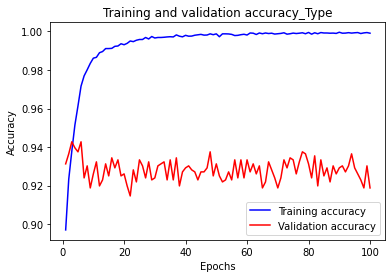

In [ ]:
import matplotlib.pyplot as plt

def plot_training_accuracy(history):

  acc_t = history.history['sparse_categorical_accuracy']
  val_acc_t = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc_t) + 1)

  plt.plot(epochs, acc_t, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc_t, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy_Type')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
plot_training_accuracy(history)

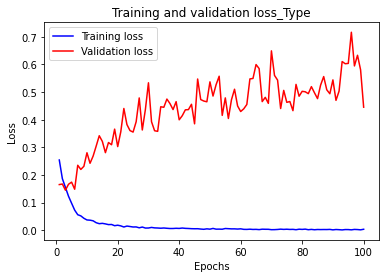

In [ ]:
import matplotlib.pyplot as plt

def plot_training_loss(history):

  loss_t = history.history['loss']
  val_loss_t = history.history['val_loss']

  epochs = range(1, len(loss_t) + 1)

  plt.plot(epochs, loss_t, 'b', label='Training loss')
  plt.plot(epochs, val_loss_t, 'r', label='Validation loss')
  plt.title('Training and validation loss_Type')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
plot_training_loss(history)

## 4. Guardado de los pesos del modelo y los tokenizers

In [ ]:
model_name = 'vGPU_s2s_model_' + str(batch_size) + 'bs' + '128ld' + str(epochs) + 'epo' + str(word_emb_dim) + 'word_emb' + '_2021-10-10.h5'
#msw = model.save_weights(model_name)
model.save_weights(model_name)

In [ ]:
# Save ModelFormat
#model_name = 'vCPU_s2s_model_' + str(batch_size) + 'bs' + '128ld' + str(epochs) + 'epo' + str(word_emb_dim) + 'word_emb' + str(slot_emb_dim) + 'slot_emb_2021'
#model.save(model_name)

In [ ]:
with open('/gdrive/My Drive/DSRP/' + model_name, 'wb') as wt: 
  pickle.dump(msw, wt, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
'''
with open('/gdrive/My Drive/PEPS/word_tokenizer', 'wb') as w_tok:
  pickle.dump(word_tokenizer, w_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/slot_tokenizer', 'wb') as s_tok:
  pickle.dump(slot_tokenizer, s_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/type_tokenizer', 'wb') as t_tok:
  pickle.dump(type_tokenizer, t_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/state_tokenizer', 'wb') as st_tok:
  pickle.dump(state_tokenizer, st_tok, protocol=pickle.HIGHEST_PROTOCOL)

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')
'''

PENDIENTES:

1) Prueba de modelos (cambiar los hiperparámetros)
* word embeddings: 128, 150, 200, 256 (250),..., 300, ..., 500
* slot embeddings: 6,..., 23 
* mantener epocas 20, 30, 50
* BATCH SIZE 16, 32, 64
* laten dim 128, 256, 200,..., 1024
* mantener pesos de pérdidas

2) Crear la función de pérdida ponderada

3) Entrenamiento final->guardamos pesos

In [ ]:
import re

fecha = '3 de abril de 2019'

año_actual = re.findall(r'\s\d{4}', fecha)

print(año_actual)

fecha_temp1 = '3 de abril del año en curso'
fecha_temp2 = '3 de abril del presente año'

replace1 = re.compile(r'( año en curso)|( presente año)')
text = re.sub(replace1, año_actual[0], fecha_temp2)

print(text)